In [73]:
from itertools import accumulate
import math
from sqlite3 import Connection

from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [115]:
target = pd.read_sql("select ra, dec from targets where target_name = 'TIC 45160946';", Connection("../../Data/astropaul.db"))
target_coord = SkyCoord(ra=target["ra"], dec=target["dec"], unit=(u.deg, u.deg), frame="icrs")[0]
radius = 0.1 * u.deg # cone search radius
job = Gaia.cone_search_async(target_coord, radius=radius)
results = job.get_results()
target_coord


INFO: Query finished. [astroquery.utils.tap.core]


<SkyCoord (ICRS): (ra, dec) in deg
    (147.61454167, -36.19191667)>

np.float64(-0.8648407085478746)

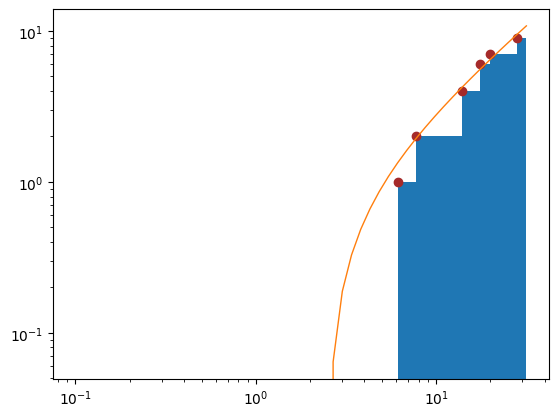

In [113]:
result_coords = SkyCoord(ra=results["ra"], dec=results["dec"])
separations = result_coords.separation(target_coord).to(u.arcsec).value
separations = sorted(separations)[1:] # assume the smallest separation is the DR3 entry for this TIC
plt.xscale("log")
plt.yscale("log")
plt.hist(separations, bins=np.logspace(-1, 1.5), cumulative=True)
hist, bins = np.histogram(separations, bins=np.logspace(-1, 1.5))
cum_hist = list(accumulate(hist))
mid_bins = [math.sqrt(a * b) for a, b in zip(bins, bins[1:])]
last_y = 0
x_vals, y_vals = [], []
for x, y in zip(bins, cum_hist):
    if y != last_y:
        x_vals.append(x)
        y_vals.append(y)
    last_y = y

m, b = np.polyfit(x_vals, y_vals, deg=1)
num_possible_contaminants = m * 0.18 + b

# plt.plot(mid_bins, cum_hist, marker="o", linewidth=0)
plt.scatter(x_vals, y_vals, color="brown")
plt.plot(bins, bins * m + b, linewidth=1)

num_possible_contaminants
